<a href="https://www.kaggle.com/code/samuraiaish/optical-character-recognition-ocr-using-dl?scriptVersionId=175849456" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Default libraries, packages for data management, visualization and Computer vision libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn package -> function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, 
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2) Helper Functions & Hyperparameters

- **This section to define all Helper functions through the notebook and any hyperparameters used later for training the models**

In [2]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-
    path: String -> the main folder directory that contains train/test folders
    ________________________________________________________________________________________________
    Return-
    DataFrame: contains the images path and label corresponding to every image
    """
    
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyz'    # to include lowercase letters only
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])
    
    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:
    path: String -> a directory of the image
    _____________________________________________________________
    Return:
    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:
    img: numpy.array of N-D
    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:
    
    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()
    
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.h5',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [3]:
# Pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 20

# 3) Reading & preparing the dataset

In [4]:
# Reading the dataset in dataframe 
main_path = '/kaggle/input/ocr-dataset/dataset'
df = directory_to_df(main_path)                   # convert the dataset into df of two columns
df.head()

The number of samples found: 85199


,image,label
0,/kaggle/input/ocr-dataset/dataset/c_L/C_L_1241...,c
1,/kaggle/input/ocr-dataset/dataset/c_L/C_L_3096...,c
2,/kaggle/input/ocr-dataset/dataset/c_L/C_L_3184...,c
3,/kaggle/input/ocr-dataset/dataset/c_L/C_L_2981...,c
4,/kaggle/input/ocr-dataset/dataset/c_L/C_L_1635...,c


In [5]:
df['label'].value_counts()

label
r    3284
e    3284
n    3281
a    3281
m    3281
q    3279
u    3278
i    3277
d    3277
y    3276
x    3276
s    3276
l    3276
k    3276
t    3276
g    3275
w    3275
h    3275
z    3275
f    3275
p    3275
o    3275
b    3274
c    3274
j    3274
v    3274
Name: count, dtype: int64

## 3.1) Splitting the dataframe
- The dataframe is splitted to get 70% of the dataset for `training` , and 30% for `testing`
- The training set is splitted into `training` and `validation` to enhance the model training

In [6]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [7]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

## 3.2) Creating generators
- The `ImageDataGenerators` is used for data augmentation, the augmentation is required since the `OCR` can work with different brightness which is not included in the dataset.
- Also, it enhance the RAM usage.

In [8]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE, 
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [9]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

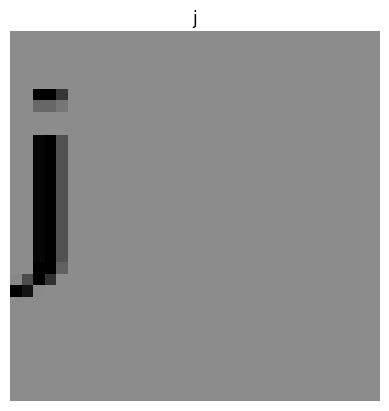

The shape of the image: (32, 32, 3)


In [10]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

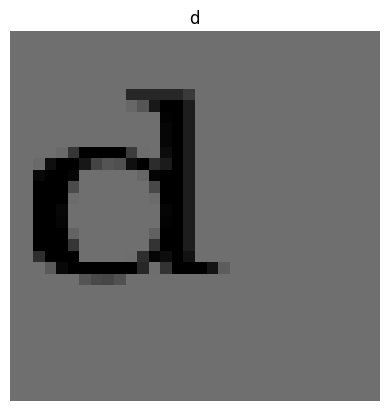

The shape of the image: (32, 32, 3)


In [11]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

DenseNet121 

In [12]:
# DenseNset121 input layers will not be FREEZED
train_layers = DenseNet121(include_top=False, input_shape=IMG_SIZE)
Den = Sequential()
Den.add(train_layers)
Den.add(Flatten())
Den.add(Dense(1024, activation='selu'))
Den.add(Dense(512, activation='selu'))
Den.add(Dense(len(mapping), activation='softmax'))

29084464/29084464 [==============================] - 0s 0us/step


In [13]:
Den.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 26)                13338     
                                                                 
Total params: 8625242 (32.90 MB)
Trainable params: 8541594 (32.58 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [14]:
optimizer = tf.keras.optimizers.legacy.Adam()
Den.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [15]:
history5 = Den.fit(train_gen, validation_data=valid_gen, epochs=18, callbacks=clbck("DenseNet121"))

Epoch 1/18
1398/1398 [==============================] - ETA: 0s - loss: 0.8985 - accuracy: 0.7690
Epoch 1: val_loss improved from inf to 0.53409, saving model to DenseNet121_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1398/1398 [==============================] - 417s 287ms/step - loss: 0.8985 - accuracy: 0.7690 - val_loss: 0.5341 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 2/18
1397/1398 [============================>.] - ETA: 0s - loss: 0.8851 - accuracy: 0.7552
Epoch 2: val_loss did not improve from 0.53409
1398/1398 [==============================] - 84s 60ms/step - loss: 0.8859 - accuracy: 0.7550 - val_loss: 102.9498 - val_accuracy: 0.0419 - lr: 0.0010
Epoch 3/18
1397/1398 [============================>.] - ETA: 0s - loss: 0.6986 - accuracy: 0.8015
Epoch 3: val_loss did not improve from 0.53409
1398/1398 [==============================] - 80s 57ms/step - loss: 0.6983 - accuracy: 0.8016 - val_loss: 9.3204 - val_accuracy: 0.5568 - lr: 0.0010
Epoch 4/18
1397/1398 [============================>.] - ETA: 0s - loss: 0.5238 - accuracy: 0.8548
Epoch 4: val_loss did not improve from 0.53409
1398/1398 [==============================] - 81s 58ms/step - loss: 0.5250 - accuracy: 0.8546 - val_loss: 8.6852 - val

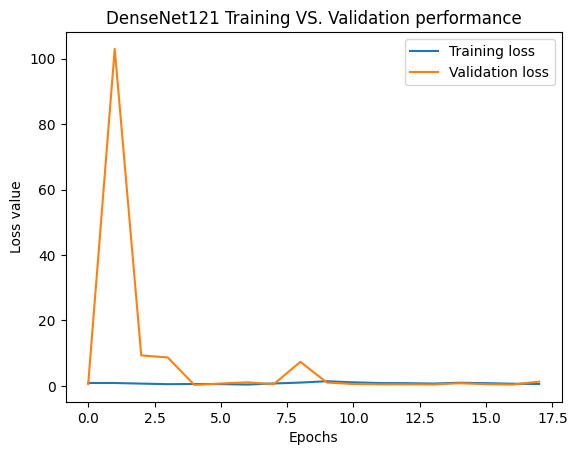

In [16]:
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("DenseNet121 Training VS. Validation performance")
plt.show()

In [17]:
# Making a prediction out of the DenseNet121 for the testing set for the evaluation
prediction = Den.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 [==============================] - 177s 219ms/step


In [18]:
print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

		The DenseNet121 Evaluation Performance
              precision    recall  f1-score   support

           a       0.77      0.66      0.71       992
           b       0.97      0.72      0.83       929
           c       0.78      0.48      0.59      1008
           d       0.83      0.78      0.80       999
           e       0.99      0.55      0.71       973
           f       0.95      0.71      0.82      1000
           g       0.81      0.68      0.74       957
           h       0.89      0.76      0.82       973
           i       0.78      0.68      0.73       969
           j       0.74      0.83      0.78       931
           k       0.99      0.74      0.85      1000
           l       0.96      0.42      0.59       974
           m       0.97      0.77      0.85      1005
           n       0.79      0.78      0.78       951
           o       0.71      0.74      0.73       951
           p       1.00      0.77      0.87       982
           q       0.16      0.99      0

In [19]:
# Den.save('densenet.h5')

In [33]:
# Computer Vision - Low level techniques
def load_model():
    model_path = '/kaggle/working/DenseNet121_model.h5'
    model = tf.keras.saving.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])
        
    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects



In [43]:
import cv2
import numpy as np

def extract(image):
    model = load_model()  # Assuming load_model() loads your OCR model
    chars = []            # a list to store recognized characters
    
    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img, words=True)
    words = find_rect(full_dil_img)  # Recognized words within the image 

    # Calculate a threshold based on a fraction of the maximum diagonal length
    diagonal_lengths = [np.sqrt(w**2 + h**2) for x, y, w, h in words]
    max_diagonal_length = max(diagonal_lengths)
    threshold_fraction = 0.4  # Adjust this fraction according to your needs
    threshold = max_diagonal_length * threshold_fraction

    for word, diagonal_length in zip(words, diagonal_lengths):
        x, y, w, h = word  # coordinates of the word

        # Skip rectangles with diagonal length less than the threshold
        if diagonal_length < threshold:
            continue

        img = image_cpy[y:y+h, x:x+w]

        # Apply median filtering for noise reduction
        img_filtered = cv2.medianBlur(img, 5)

        _, bin_img = binarization(convert_2_gray(img_filtered))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)  # Recognized chars within the word

        # Only draw a green rectangle if the box is not too small
        if w * h > 100:  # Adjust this threshold according to your needs
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)  # draw a green rectangle around the word

        for char in char_parts:
            x_c, y_c, w_c, h_c = char
            ch = img_filtered[y_c:y_c+h_c, x_c:x_c+w_c]

            empty_img = np.full((32, 32, 1), 255, dtype=np.uint8)  # a white image used for resize with filling
            x_fill, y_fill = 3, 3  # starting indices
            resized = cv2.resize(ch, (16, 22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y_fill:y_fill+22, x_fill:x_fill+16, 0] = gray.copy()  # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)
            
            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)  # append the character into the list
            
            # Calculate position to draw the text at the bottom of the rectangle
            text_x = x + x_c
            text_y = y + h + 30  # Place the text below the green box
            
            # Overlay the recognized character on the original image with increased size and black color
            cv2.putText(image, predicted, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3, cv2.LINE_AA)

    del model
    show_image(image)
    return ' '.join(chars[:-1])


## 6.1) Testing

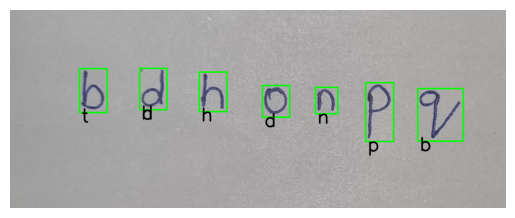

--> t h d h d n p


In [44]:
# Testing 1
img = read_image('/kaggle/input/new-test1/WhatsApp Image 2024-05-01 at 12.26.20.jpeg')
text = extract(img)
print('-->',text)

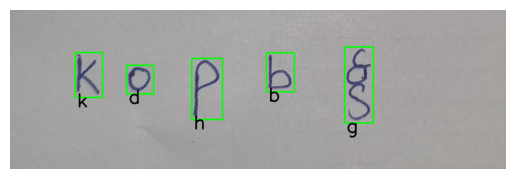

--> k d h b


In [45]:
# Testing 2
img2 = read_image('/kaggle/input/testcase123/WhatsApp Image 2024-05-01 at 12.26.26.jpeg')
text = extract(img2)
print('-->',text)

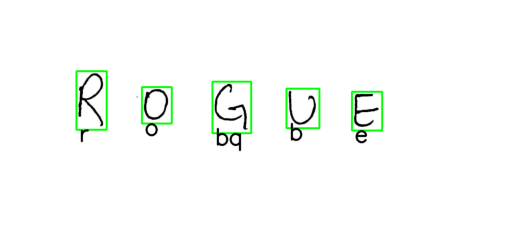

--> r o b q b


In [46]:
# Testing 3
img3 = read_image('/kaggle/input/asd123/WhatsApp Image 2024-05-01 at 12.33.04.jpeg')
text = extract(img3)
print('-->',text)